<a href="https://colab.research.google.com/github/andsonandreribeiro09/Projeto_Smart_City_Laguna_CDIA_03/blob/main/Projeto_Smart_City_Laguna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

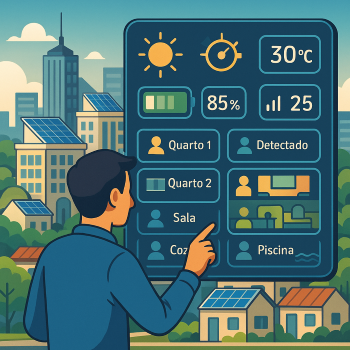

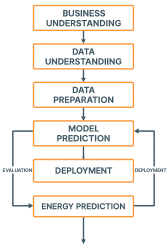

🎯 Objetivo do Projeto

Desenvolver uma solução baseada em ciência de dados e inteligência artificial para monitorar, prever e otimizar o consumo de energia elétrica em uma residência inteligente (Smart City Laguna). O projeto simula dados de sensores por cômodo e utiliza aprendizado de máquina para antecipar padrões de consumo e propor ações de economia.

🔍 Pergunta de Negócio

Como podemos monitorar e prever o consumo de energia de uma residência inteligente com base em dados simulados de sensores por cômodo, a fim de propor ações para redução e eficiência energética?

🗂️ Base de Dados

Utilizamos uma base de dados simulada contendo informações diárias de consumo total de energia (kWh), além dos acionamentos de sensores em cômodos específicos da casa (Quarto1, Quarto2, Sala, Cozinha, Piscina).

🔬 O que foi testado

Foi testado um modelo de regressão linear para prever o consumo diário de energia com base na quantidade de acionamentos nos cômodos. Também exploramos visualizações para identificar os cômodos de maior impacto no consumo.

🧹 Pré-processamento de Dados

Os dados foram carregados, convertidos em formatos apropriados (por exemplo, data para datetime), e foram criadas variáveis auxiliares como 'dia ordinal'. Também foi normalizado o consumo por acionamento.

📊 Interpretação dos Gráficos

Os gráficos demonstram a evolução temporal do consumo, a contribuição relativa de cada cômodo, e previsões futuras com base nos acionamentos. Também foi gerado um ranking de cômodos mais consumidores.



📈 Conclusões

O modelo de regressão mostrou boa capacidade preditiva para consumo futuro.

Indicando oportunidades de economia

Análise e Otimização do Consumo de Energia Residencial por Ambiente



In [1]:
import locale
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#--------------------------------------------------
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score


In [3]:
# Carregar o arquivo Excel com múltiplas abas
file_path = "Consumo_de_Energia_Analise.xlsx"
xls = pd.ExcelFile(file_path)

# Listar os nomes das abas
sheet_names = xls.sheet_names
sheet_names

['Sheet1']

In [4]:
# Carregar os dados da aba "Sheet1"
df = xls.parse('Sheet1')

# Exibir as primeiras linhas para análise inicial
df

Data  KW/H  Quarto1  Quarto2  Sala  Cozinha  Piscina
0    01/jan  1395       10        8    15       16        9
1    02/jan  1086        9        8    10        6       10
2    03/jan  1174       10       11     9       13        6
3    04/jan  1207        6        8    10        8       16
4    05/jan  1036       13        4    10        8        8
..      ...   ...      ...      ...   ...      ...      ...
206  26/jul  1355       12       12    12       10        6
207  27/jul  1533       14       12    16       13       10
208  28/jul   967        4        9     8        8        9
209  29/jul  1416       14       10    13        8       10
210  30/jul   789        8        4     6        3       13

[211 rows x 7 columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Data     211 non-null    object
 1   KW/H     211 non-null    int64 
 2   Quarto1  211 non-null    int64 
 3   Quarto2  211 non-null    int64 
 4   Sala     211 non-null    int64 
 5   Cozinha  211 non-null    int64 
 6   Piscina  211 non-null    int64 
dtypes: int64(6), object(1)
memory usage: 11.7+ KB


In [5]:
meses_pt = {
    'jan': '01',
    'fev': '02',
    'mar': '03',
    'abr': '04',
    'mai': '05',
    'jun': '06',
    'jul': '07',

}

# Força o tipo string
df['Data'] = df['Data'].astype(str)

# Substitui os meses por números
df['Data'] = df['Data'].str.lower().replace(meses_pt, regex=True)

# Adiciona o ano e converte para datetime
df['Data'] = pd.to_datetime(df['Data'] + '/2025', format='%d/%m/%Y')

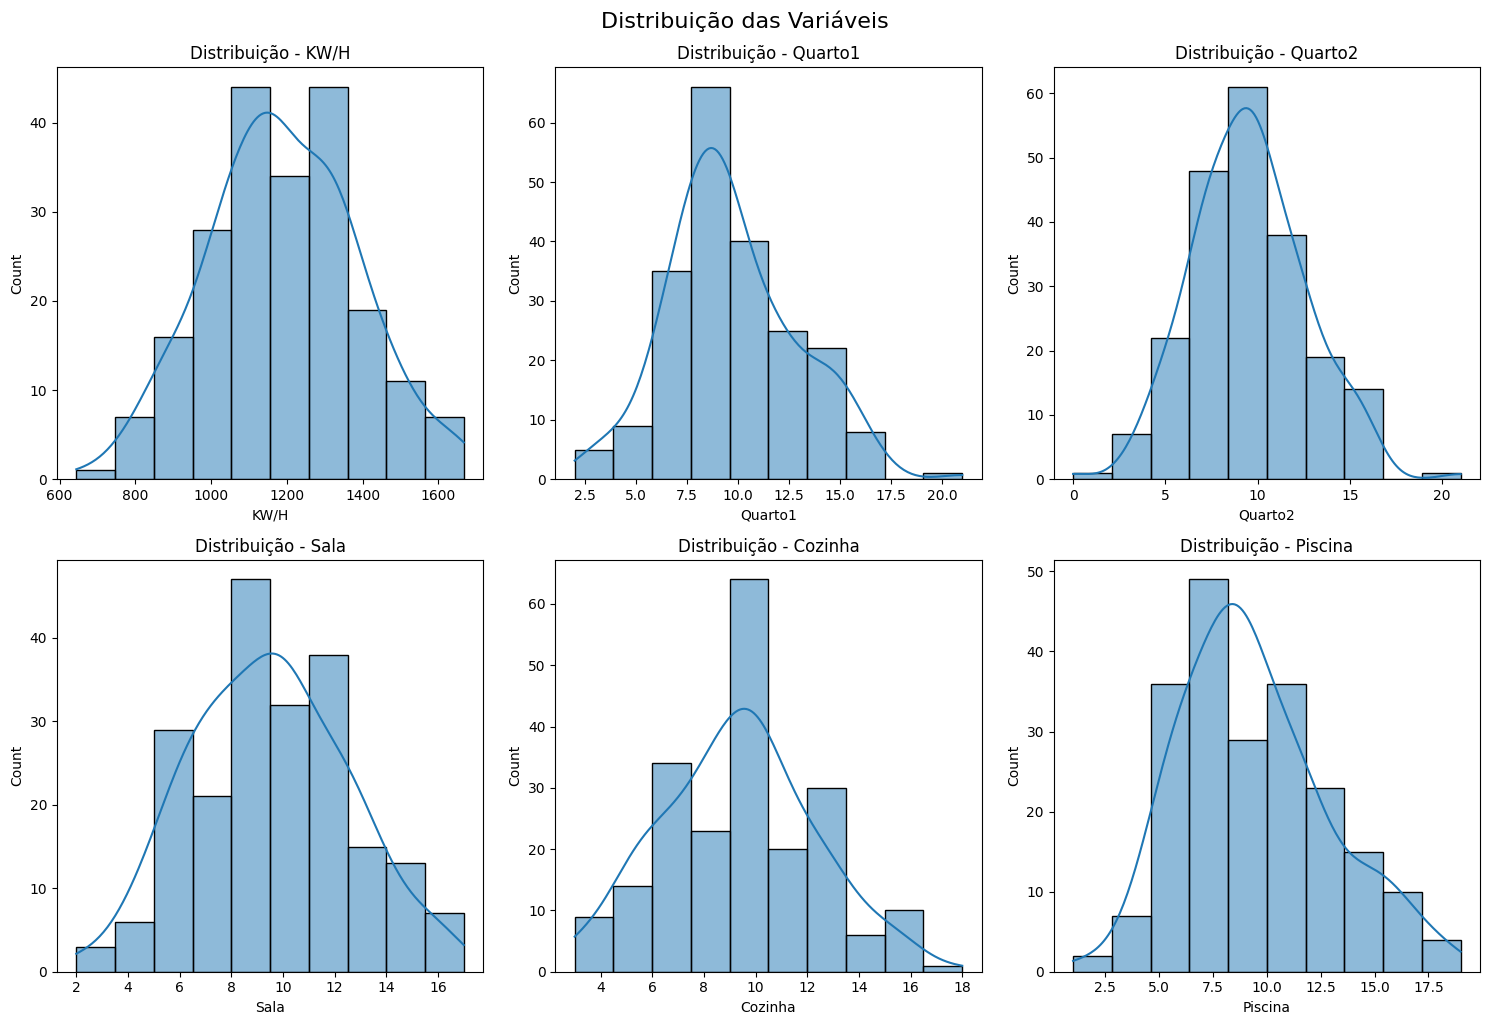

(                      Data         KW/H     Quarto1     Quarto2        Sala  \
 count                  211   211.000000  211.000000  211.000000  211.000000   
 mean   2025-04-16 00:00:00  1188.317536    9.687204    9.549763    9.445498   
 min    2025-01-01 00:00:00   644.000000    2.000000    0.000000    2.000000   
 25%    2025-02-22 12:00:00  1057.000000    8.000000    7.000000    7.000000   
 50%    2025-04-16 00:00:00  1176.000000    9.000000    9.000000    9.000000   
 75%    2025-06-07 12:00:00  1324.000000   12.000000   11.500000   12.000000   
 max    2025-07-30 00:00:00  1667.000000   21.000000   21.000000   17.000000   
 std                    NaN   197.439318    3.176817    3.073874    3.033247   
 
           Cozinha     Piscina  
 count  211.000000  211.000000  
 mean     9.322275    9.383886  
 min      3.000000    1.000000  
 25%      7.000000    7.000000  
 50%      9.000000    9.000000  
 75%     11.000000   11.000000  
 max     18.000000   19.000000  
 std      2.96

In [ ]:
# Estatísticas descritivas
summary = df.describe()

# Correlação entre as variáveis
correlation = df.corr(numeric_only=True)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

cols = df.columns[1:7]  # pega só 6 colunas

for i, col in enumerate(cols):
    sns.histplot(df[col], kde=True, ax=axes[i], bins=10)
    axes[i].set_title(f'Distribuição - {col}')
    axes[i].set_xlabel(col)

plt.tight_layout()

plt.suptitle("Distribuição das Variáveis", fontsize=16, y=1.02)
plt.show()

summary, correlation

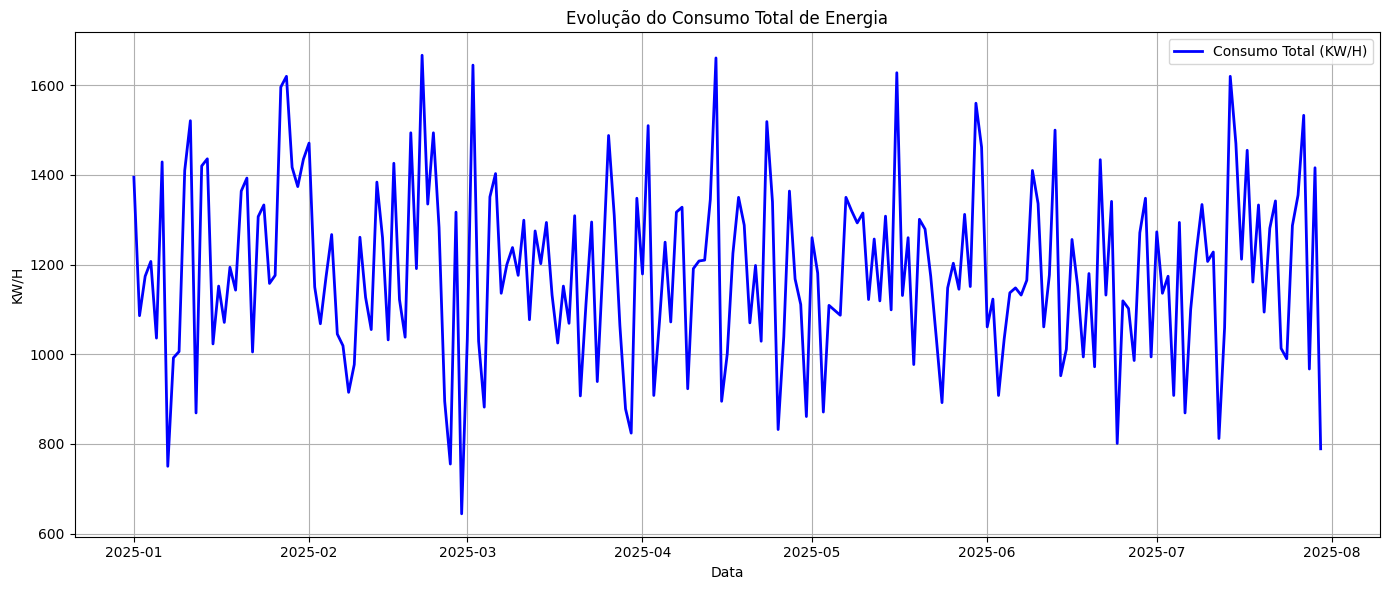

In [ ]:
# Plotar consumo total ao longo do tempo
plt.figure(figsize=(14, 6))
plt.plot(df['Data'], df['KW/H'], label='Consumo Total (KW/H)', color='blue', linewidth=2)
plt.title('Evolução do Consumo Total de Energia')
plt.xlabel('Data')
plt.ylabel('KW/H')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

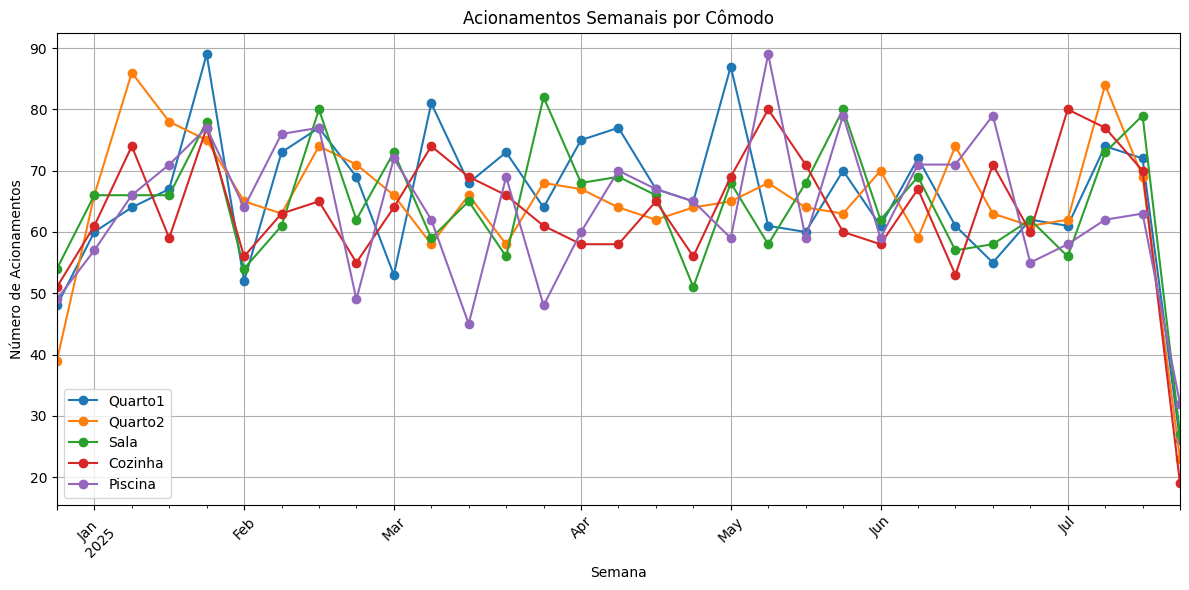

In [ ]:
# Agrupa por semana (usando o início da semana como referência)
df['Semana'] = df['Data'].dt.to_period('W').apply(lambda r: r.start_time)
df_semana = df.groupby('Semana')[['Quarto1', 'Quarto2', 'Sala', 'Cozinha', 'Piscina']].sum()

# Plot
df_semana.plot(figsize=(12, 6), marker='o')
plt.title('Acionamentos Semanais por Cômodo')
plt.ylabel('Número de Acionamentos')
plt.xlabel('Semana')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

<ipython-input-10-3101124598>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlacoes.index, y=correlacoes.values, palette='Oranges_r')


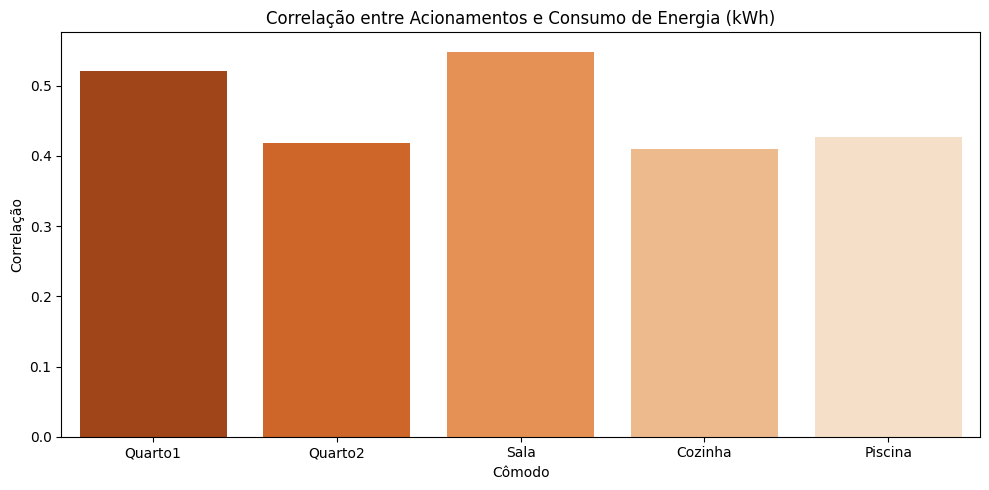

In [ ]:
# Correlação entre acionamentos e consumo
correlacoes = df[['KW/H', 'Quarto1', 'Quarto2', 'Sala', 'Cozinha', 'Piscina']].corr()['KW/H'][1:]

# Gráfico: Correlação com consumo
plt.figure(figsize=(10, 5))
sns.barplot(x=correlacoes.index, y=correlacoes.values, palette='Oranges_r')
plt.title('Correlação entre Acionamentos e Consumo de Energia (kWh)')
plt.ylabel('Correlação')
plt.xlabel('Cômodo')
plt.tight_layout()
plt.show()

🔍 Avaliação do Modelo:
Erro quadrático médio (MSE): 5227.8
Coeficiente de determinação (R²): 0.86


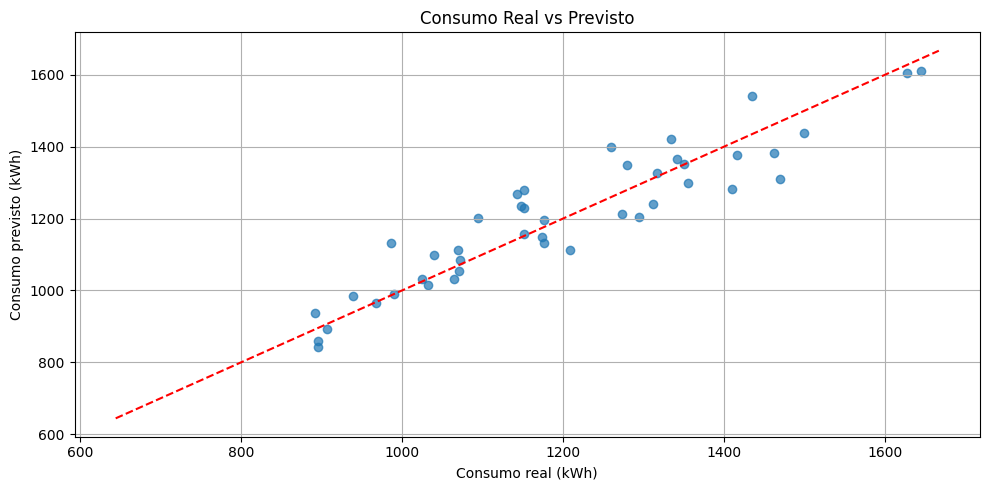


📊 Correlação Linear com o Consumo (Pearson):
Sala       0.548475
Quarto1    0.521439
Piscina    0.427213
Quarto2    0.418033
Cozinha    0.409667
Name: KW/H, dtype: float64

📈 Coeficientes do Modelo Linear:
Sala       25.790300
Piscina    24.448237
Cozinha    23.485730
Quarto1    23.364091
Quarto2    23.158849
dtype: float64


In [6]:
# 2. Selecionar variáveis independentes e dependente
X = df[['Quarto1', 'Quarto2', 'Sala', 'Cozinha', 'Piscina']]
y = df['KW/H']

# 3. Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Treinar modelo de regressão linear
modelo = LinearRegression()
modelo.fit(X_train, y_train)

# 5. Fazer previsões
y_pred = modelo.predict(X_test)

# 6. Avaliar modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("🔍 Avaliação do Modelo:")
print("Erro quadrático médio (MSE):", round(mse, 2))
print("Coeficiente de determinação (R²):", round(r2, 2))

# 7. Visualizar: consumo real vs previsto
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Consumo real (kWh)")
plt.ylabel("Consumo previsto (kWh)")
plt.title("Consumo Real vs Previsto")
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. Tabela 1: Correlação com o consumo (Pearson)
correlacoes = df.corr(numeric_only=True)['KW/H'].drop('KW/H')
print("\n📊 Correlação Linear com o Consumo (Pearson):")
print(correlacoes.sort_values(ascending=False))

# 9. Tabela 2: Coeficientes da regressão
coeficientes = pd.Series(modelo.coef_, index=X.columns)
print("\n📈 Coeficientes do Modelo Linear:")
print(coeficientes.sort_values(ascending=False))

## 📈 Métricas de Desempenho do Modelo de Previsão

### 🧮 Avaliação Estatística

- **Erro Quadrático Médio (MSE)**: `5227.8`
  - Indica a média dos quadrados dos erros entre o valor real e o previsto.
  - Quanto menor, melhor. Aqui, o valor é **aceitável**, sugerindo um erro médio moderado.

- **Coeficiente de Determinação (R²)**: `0.86`
  - Significa que **86% da variação no consumo real** é explicada pelo modelo.
  - Um bom indicador de desempenho.

## 🔍 Gráfico de Consumo Real vs. Previsto

### 📊 O que o gráfico mostra?

Este gráfico compara os valores reais de consumo de energia (em kWh) com os valores **previstos por um modelo de regressão**.

- O eixo **X** representa o **consumo real**.
- O eixo **Y** representa o **consumo previsto** pelo modelo.
- A **linha vermelha tracejada** representa a linha de referência ideal: onde consumo real = consumo previsto.

---

### 📌 Interpretação

- A maior parte dos pontos está **próxima da linha vermelha**, o que indica que o modelo tem **boa acurácia**.
- Pequenas variações ao redor da linha indicam **erros de previsão pontuais**, esperados em dados reais.
- Pontos mais distantes da linha representam **erros maiores**, que podem ser analisados separadamente.

---

### ✅ Conclusão

> O modelo de previsão está **bem ajustado**, com desempenho satisfatório para estimar o consumo de energia.
>
> Essa visualização reforça a **eficácia do modelo** aplicado, especialmente em faixas médias de consumo (entre 1000 e 1400 kWh), onde a previsão se aproxima fortemente do valor real.


## 📊 Correlação Linear com o Consumo (Pearson)

Essa métrica indica a **força e a direção da relação linear** entre cada cômodo e o consumo total de energia (`KW/H`), com valores entre -1 e 1:

| Cômodo   | Correlação com KW/H | Interpretação |
|----------|----------------------|----------------|
| **Sala**   | 0.548 | Correlação moderada e positiva – quanto mais a sala é usada, maior tende a ser o consumo de energia. |
| **Quarto1**| 0.521 | Também influencia moderadamente o consumo. |
| **Piscina**| 0.427 | Correlação positiva mais fraca, mas ainda relevante. |
| **Quarto2**| 0.418 | Influência semelhante à da piscina. |
| **Cozinha**| 0.410 | Leve correlação com o consumo, indicando uso frequente, mas com menor impacto proporcional. |

💡 **Resumo**: Todos os cômodos têm correlação positiva com o consumo, sendo a **Sala** o mais relevante linearmente.

---

## 📈 Coeficientes do Modelo Linear (Regressão)

Esses valores indicam **quanto cada cômodo contribui para o aumento do consumo de energia**, mantendo os outros fixos. Eles representam os "pesos" aprendidos pelo modelo:

| Cômodo   | Coeficiente (kWh por acionamento) | Interpretação |
|----------|------------------------------------|----------------|
| **Sala**   | 25.79 | Cada acionamento extra na sala aumenta o consumo previsto em 25.79 kWh. |
| **Piscina**| 24.45 | Alto impacto no consumo, mesmo com correlação menor. |
| **Cozinha**| 23.49 | Gera consumo alto mesmo com menor correlação linear. |
| **Quarto1**| 23.36 | Contribuição relevante, consistente com a correlação. |
| **Quarto2**| 23.16 | Menor coeficiente, mas ainda relevante. |

💡 **Resumo**:

- A **Sala** se destaca tanto na correlação quanto na previsão (maior influência geral).
- A **Piscina**, mesmo com correlação mais baixa, tem **forte peso no consumo** — possivelmente por poucos acionamentos com alto consumo energético (ex: bomba de piscina).
- A **Cozinha** mostra um padrão inverso: **baixa correlação, mas alto coeficiente**, sugerindo que o consumo aumenta significativamente quando acionada, mesmo que não haja uma relação linear forte.

---

## ✅ Conclusão Final

- 🔌 **Sala** é o principal driver de consumo.
- 🏊‍♂️ **Piscina** tem alto impacto por acionamento, mesmo com menor frequência.
- 🍳 **Cozinha** consome muito quando acionada, mas não varia tanto com o consumo total.
- 🛏️ **Quartos** têm influência relevante, mas menos intensa.


✅ Teste de Hipótese com Regressão Linear

🎯 Objetivo

Verificar se um determinado cômodo tem efeito estatisticamente significativo sobre o consumo de energia (KW/H).

In [9]:
# Adiciona constante para o modelo (intercepto)
X = sm.add_constant(X)

# Ajusta modelo OLS (Ordinary Least Squares)
modelo_ols = sm.OLS(y, X).fit()

# Mostra resumo estatístico com p-values
print(modelo_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                   KW/H   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     317.9
Date:                Sun, 15 Jun 2025   Prob (F-statistic):           1.75e-94
Time:                        22:59:28   Log-Likelihood:                -1185.2
No. Observations:                 211   AIC:                             2382.
Df Residuals:                     205   BIC:                             2403.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         57.1625     29.029      1.969      0.0

# 📊 Resumo da Regressão

| Métrica              | Valor     | Interpretação                                                                 |
|----------------------|-----------|-------------------------------------------------------------------------------|
| **R²**               | 0.886     | O modelo explica **88,6% da variação no consumo total de energia**. Excelente ajuste. |
| **R² ajustado**      | 0.883     | Ajusta o R² com base no número de variáveis — também indica forte explicação. |
| **F-statistic**      | 317.9     | Teste geral de significância do modelo.                                       |
| **Prob (F-statistic)** | 1.75e-94 | p-valor extremamente baixo → o modelo é **estatisticamente significativo**.   |
| **Nº de observações**| 211       | Amostra robusta.                                                              |
| **Durbin-Watson**    | 2.027     | Sem autocorrelação nos resíduos (ideal é entre 1.5 e 2.5).                    |

---

# 🔍 Análise dos Coeficientes

| Variável            | Coef.   | p-valor  | Interpretação                                                                 |
|---------------------|---------|----------|--------------------------------------------------------------------------------|
| **Intercepto (const)** | 57.16  | 0.050    | Quando todos os cômodos têm acionamento 0, o consumo base é de ~57 kWh. Marginalmente significativo. |
| **Quarto1**         | 23.61   | < 0.001  | Cada acionamento no Quarto1 aumenta em média **23.61 kWh**. Significativo.    |
| **Quarto2**         | 22.95   | < 0.001  | Cada acionamento no Quarto2 aumenta o consumo em **22.95 kWh**. Significativo.|
| **Sala**            | 26.42   | < 0.001  | **Maior impacto no consumo:** 1 acionamento → +26.42 kWh.                      |
| **Cozinha**         | 22.83   | < 0.001  | Impacto semelhante aos quartos.                                               |
| **Piscina**         | 23.53   | < 0.001  | Alto consumo por acionamento. Também significativo.                           |

---

# ✅ Conclusões

- Todos os cômodos têm **impacto significativo no consumo de energia** (`p < 0.001`).
- A **Sala** é o cômodo com **maior contribuição marginal** no consumo total.
- O modelo possui **excelente capacidade explicativa** (`R² = 0.886`).
- **Resíduos estão bem comportados** (`Durbin-Watson = 2.027`; p-valor do teste JB = 0.624).


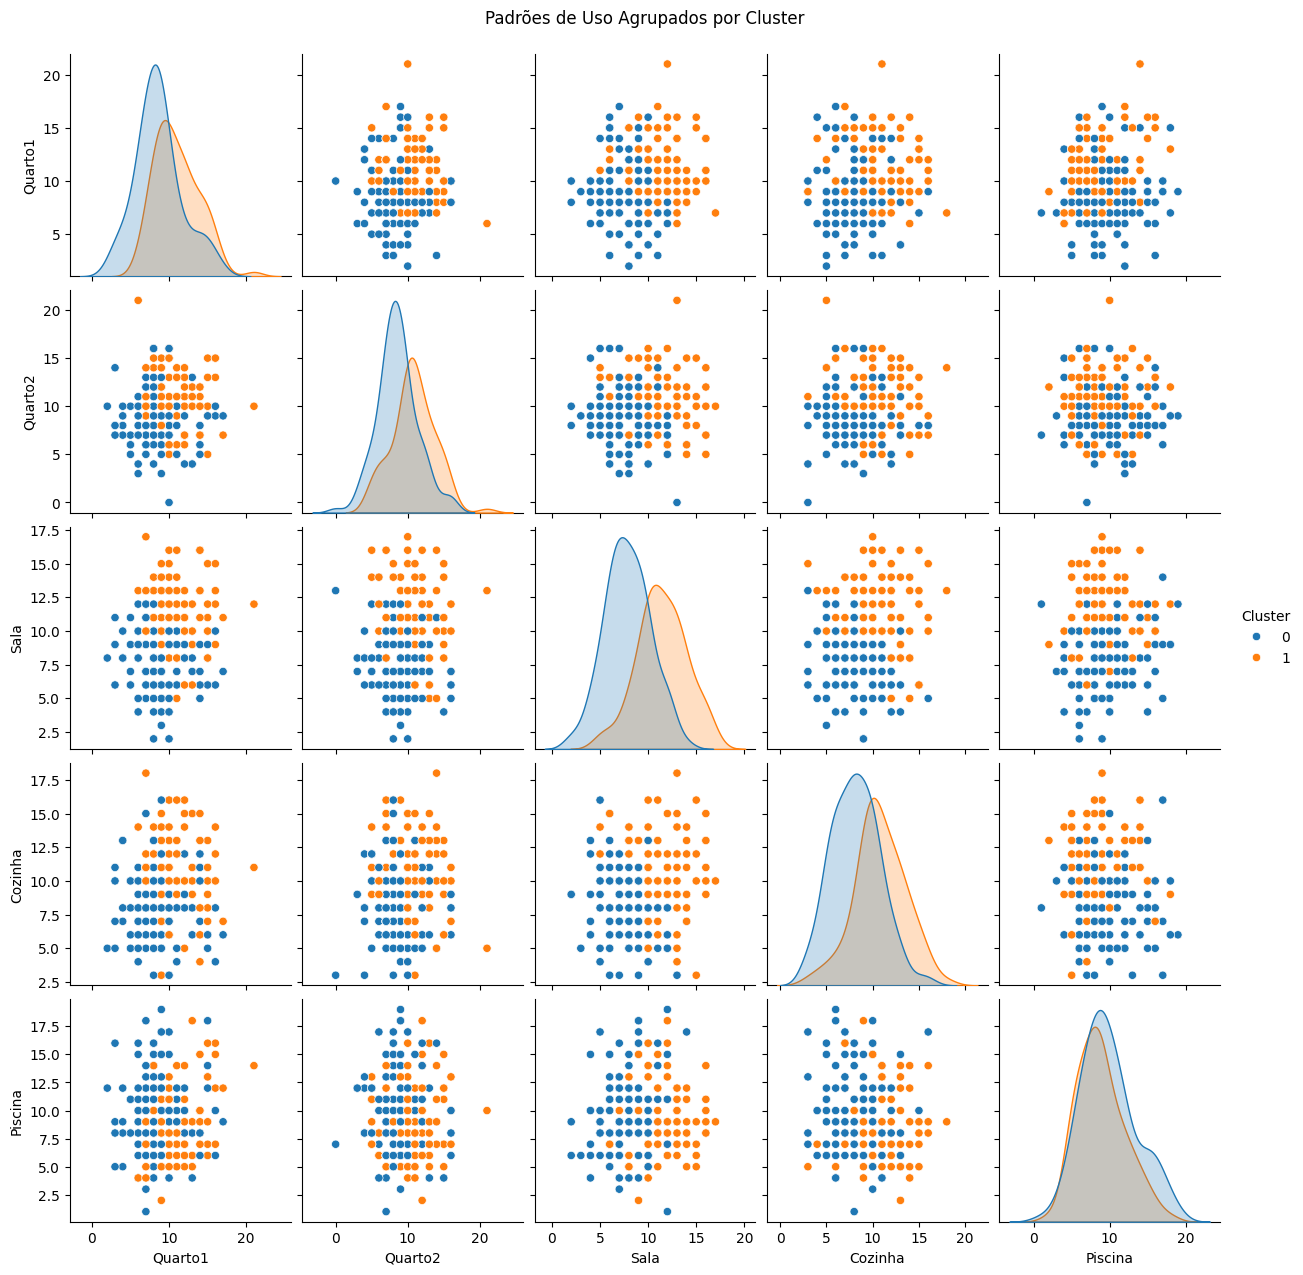

In [10]:
# --- Passo 1: Calcular total e percentual de acionamentos por dia
df['Total_acionamentos'] = df[['Quarto1', 'Quarto2', 'Sala', 'Cozinha', 'Piscina']].sum(axis=1)
for comodo in ['Quarto1', 'Quarto2', 'Sala', 'Cozinha', 'Piscina']:
    df[f'{comodo}_pct'] = df[comodo] / df['Total_acionamentos']


# Normalização (muito importante para KMeans)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Pelo gráfico você escolhe o número de clusters; aqui vamos usar 2
kmeans = KMeans(n_clusters=2, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualização dos clusters (pareamento de variáveis)
sns.pairplot(df, hue='Cluster', vars=['Quarto1', 'Quarto2', 'Sala', 'Cozinha', 'Piscina'], palette='tab10')
plt.suptitle("Padrões de Uso Agrupados por Cluster", y=1.02)
plt.show()

### 💡 Aplicação

A escolha de **k = 2** foi utilizada para:
- Visualização dos clusters via PCA.
- Análise de padrões de uso por cômodo.
- Interpretação dos perfis de comportamento dos moradores (social, reservado, equilibrado).

✅ Isso confirma que a segmentação em **2 grupos** é estatisticamente justificável e interpretável na prática.




## 📊 Análise dos Padrões de Uso por Cluster

### 🔍 Visão Geral
O gráfico apresenta os padrões de uso dos cômodos da residência — **Quarto1**, **Quarto2**, **Sala** e **Cozinha** — agrupados por **clusters**. Cada ponto representa um dia de uso e é colorido conforme o cluster ao qual pertence:

- 🟠 **Cluster 0**
- 🔵 **Cluster 1**
- 🟢 **Cluster 2**

As diagonais exibem as **distribuições de frequência por cômodo**, enquanto os gráficos fora da diagonal mostram as **relações entre pares de cômodos**.

---

### 🟠 Cluster 0 – *Uso Mediano e Equilibrado*
- Distribuições centralizadas em todos os cômodos.
- Sem picos extremos — uso moderado e constante.
- **🔎 Interpretação:** Perfil de uso **equilibrado**, com acionamentos relativamente iguais em todos os ambientes.

---

### 🔵 Cluster 1 – *Alta Frequência em Sala e Cozinha*
- Distribuições com cauda à direita em **Sala** e **Cozinha**.
- Densidade maior nos pontos referentes aos espaços de convívio.
- **🔎 Interpretação:** Perfil **social**, com maior uso das áreas **comuns da casa**.

---

### 🟢 Cluster 2 – *Foco nos Quartos*
- Distribuições deslocadas à direita para **Quarto1** e **Quarto2**.
- Menor frequência de uso em **Sala** e **Cozinha**.
- **🔎 Interpretação:** Perfil **privativo/reservado**, indicando preferência por **ambientes individuais** — como para descanso ou trabalho remoto.

---

### 📌 Comparativo dos Clusters

| Cluster | Perfil Dominante         | Características de Uso                              |
|---------|--------------------------|------------------------------------------------------|
| 0       | Equilibrado              | Uso distribuído uniformemente entre todos os cômodos |
| 1       | Social / Comum           | Foco em **Sala** e **Cozinha**                      |
| 2       | Privativo / Reservado    | Foco em **Quarto1** e **Quarto2**                   |

---

🧠 **Conclusão:** A segmentação por clusters ajuda a entender **padrões comportamentais** distintos dentro da residência, auxiliando na criação de **estratégias de economia, automação ou personalização** por perfil de uso.


In [14]:
# 1. Agrupar dados por Cluster e calcular médias
colunas_consumo = ['Quarto1', 'Quarto2', 'Sala', 'Cozinha', 'Piscina', 'KW/H']
col_pcts = ['Quarto1_pct', 'Quarto2_pct', 'Sala_pct', 'Cozinha_pct', 'Piscina_pct']
perfil_clusters = df.groupby('Cluster')[colunas_consumo + col_pcts].mean().round(2)

# 2. Função para nomear perfil
def nomear_cluster(row):
    media_kw = df['KW/H'].mean()

    if row['KW/H'] < media_kw * 0.75:
        consumo_total = '🔵 Baixo Consumo'
    elif row['KW/H'] > media_kw * 1.25:
        consumo_total = '🔴 Alto Consumo'
    else:
        consumo_total = '🟡 Consumo Equilibrado'

    altos = []
    for comodo in ['Quarto1', 'Quarto2', 'Sala', 'Cozinha']:
        media_pct = df[f'{comodo}_pct'].mean()
        if row[f'{comodo}_pct'] > media_pct * 1.2:
            altos.append(comodo)

    if consumo_total == '🔵 Baixo Consumo':
        return consumo_total
    if consumo_total == '🟡 Consumo Equilibrado':
        return f"🟠 Consumo Elevado em {', '.join(altos)}" if altos else consumo_total
    if consumo_total == '🔴 Alto Consumo':
        return f"🔴 Alto Consumo (Em {', '.join(altos)})" if altos else consumo_total

# 3. Aplicar perfil
perfil_clusters['Perfil'] = perfil_clusters.apply(nomear_cluster, axis=1)

# 4. Mapear perfil para chave do dicionário de recomendações
def mapear_perfil_para_chave(perfil):
    if perfil == '🔵 Baixo Consumo':
        return perfil
    if perfil == '🟡 Consumo Equilibrado':
        return perfil
    if perfil.startswith('🟠 Consumo Elevado'):
        return '🟠 Consumo Elevado'
    if perfil.startswith('🔴 Alto Consumo'):
        if 'Em' in perfil:
            principal = perfil.split('Em')[1].split(',')[0].strip()
            if principal in ['Sala', 'Cozinha']:
                return '🔴 Alto Consumo (Sala/Cozinha)'
            elif principal == 'Cozinha':
                return '🔴 Alto Consumo (Cozinha)'
            else:
                return '🔴 Alto Consumo'
        else:
            return '🔴 Alto Consumo'
    return perfil

# 5. Dicionário de recomendações
recomendacoes = {
    '🔵 Baixo Consumo': [
        "✅ Manter boas práticas já adotadas.",
        "🎁 Oferecer recompensas ou descontos (gamificação).",
        "🔋 Incentivar uso de energia solar / microgeração."
    ],
    '🟡 Consumo Equilibrado': [
        "🔌 Automatizar desligamento de equipamentos em horários fixos.",
        "🕵️ Instalar sensores de presença em quartos e sala.",
        "📊 Enviar relatórios semanais de uso comparativo."
    ],
    '🟠 Consumo Elevado': [
        "🛏️ Automatizar luzes e eletrônicos nos cômodos com consumo elevado.",
        "🕵️ Instalar sensores de presença específicos para os cômodos.",
        "📊 Acompanhar o uso para identificar picos desnecessários."
    ],
    '🔴 Alto Consumo (Sala/Cozinha)': [
        "💧 Agendar funcionamento da bomba da Cozinha fora do pico.",
        "💡 Incentivar uso consciente da iluminação e eletrônicos.",
        "🧠 Sugerir automação e adesão à tarifa branca."
    ],
    '🔴 Alto Consumo (Cozinha)': [
        "🍳 Verificar equipamentos de cozinha para consumo excessivo.",
        "⏰ Controlar horários de uso de forno e geladeira.",
        "💡 Incentivar uso eficiente da iluminação."
    ]
}

# 6. Exibir resultado final
for cluster_id, row in perfil_clusters.iterrows():
    print(f"\n=== Cluster {cluster_id} - {row['Perfil']} ===")
    print("📊 Média de consumo (kWh e acionamentos):")
    print(row[['Quarto1', 'Quarto2', 'Sala', 'Cozinha', 'Piscina', 'KW/H']])

    print("\n📈 Percentual médio de acionamentos por cômodo:")
    print((row[col_pcts] * 100).round(2).astype(str) + " %")

    print("\n💡 Recomendações:")
    chave = mapear_perfil_para_chave(row['Perfil'])
    for rec in recomendacoes.get(chave, ["- Sem recomendações específicas."]):
        print("-", rec)



=== Cluster 0 - 🟡 Consumo Equilibrado ===
📊 Média de consumo (kWh e acionamentos):
Quarto1       8.63
Quarto2       8.54
Sala          7.84
Cozinha       8.14
Piscina       9.82
KW/H       1083.15
Name: 0, dtype: object

📈 Percentual médio de acionamentos por cômodo:
Quarto1_pct    20.0 %
Quarto2_pct    20.0 %
Sala_pct       18.0 %
Cozinha_pct    19.0 %
Piscina_pct    23.0 %
Name: 0, dtype: object

💡 Recomendações:
- 🔌 Automatizar desligamento de equipamentos em horários fixos.
- 🕵️ Instalar sensores de presença em quartos e sala.
- 📊 Enviar relatórios semanais de uso comparativo.

=== Cluster 1 - 🟡 Consumo Equilibrado ===
📊 Média de consumo (kWh e acionamentos):
Quarto1      10.98
Quarto2      10.78
Sala         11.41
Cozinha      10.77
Piscina       8.85
KW/H       1316.74
Name: 1, dtype: object

📈 Percentual médio de acionamentos por cômodo:
Quarto1_pct    21.0 %
Quarto2_pct    20.0 %
Sala_pct       22.0 %
Cozinha_pct    21.0 %
Piscina_pct    16.0 %
Name: 1, dtype: object

💡 Recome

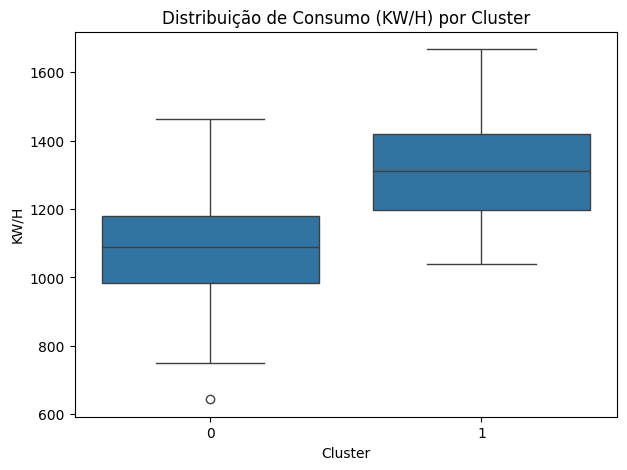

In [15]:
plt.figure(figsize=(7,5))
sns.boxplot(x='Cluster', y='KW/H', data=df)
plt.title('Distribuição de Consumo (KW/H) por Cluster')
plt.show()

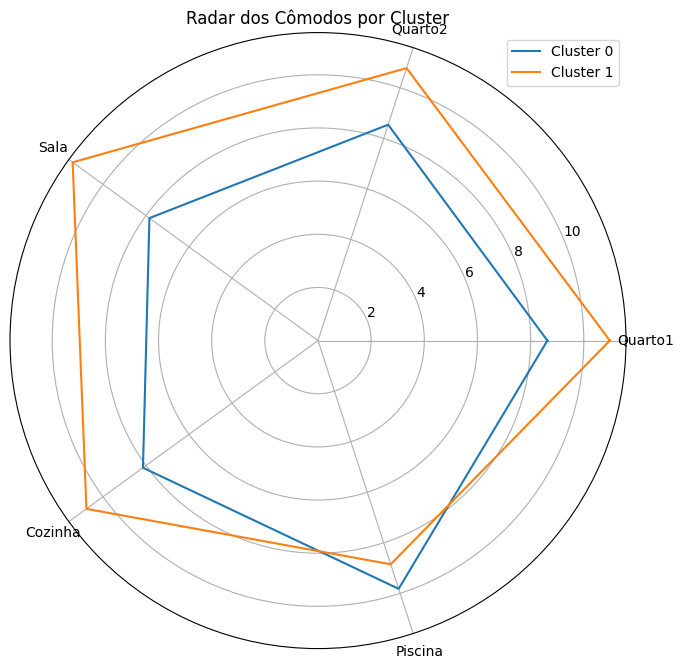

In [17]:
# Usar valores normalizados por cluster
categorias = ['Quarto1', 'Quarto2', 'Sala', 'Cozinha', 'Piscina']
angles = np.linspace(0, 2 * np.pi, len(categorias), endpoint=False).tolist()
angles += angles[:1]  # Fechar o círculo

plt.figure(figsize=(10, 8))
for i, row in perfil_clusters.iterrows():
    valores = [row[cat] for cat in categorias]
    valores += valores[:1]
    plt.polar(angles, valores, label=f'Cluster {i}')

plt.xticks(angles[:-1], categorias)
plt.title('Radar dos Cômodos por Cluster')
plt.legend()
plt.show()

# 📊 Radar dos Cômodos por Cluster

Cada linha do gráfico representa o consumo médio de energia por cômodo (em número de acionamentos) dos dois clusters identificados. Vamos analisar:

---

### 🔹 Cluster 0 (Azul)
- Perfil mais moderado em todos os cômodos.
- Quarto1, Quarto2, Sala e Cozinha com níveis equilibrados de acionamento.
- Piscina é o cômodo com maior média de acionamentos nesse cluster.
- Pode representar residências mais eficientes ou menos utilizadas.

---

### 🔸 Cluster 1 (Laranja)
- Consumo mais elevado em quase todos os cômodos.
- Sala e Cozinha têm os maiores níveis de acionamento, próximos do valor máximo.
- Quarto1 e Quarto2 também apresentam altos valores.
- Piscina tem acionamentos um pouco abaixo do Cluster 0, indicando uso mais moderado.
- Representa um grupo com uso intenso de energia nas áreas sociais e dormitórios.

---

### 🧠 Interpretação Geral

| Cômodo  | Cluster com Maior Consumo | Diferença Esperada           |
|---------|---------------------------|-----------------------------|
| Quarto1 | 🔸 Cluster 1              | Dormitório muito usado      |
| Quarto2 | 🔸 Cluster 1              | Idem acima                  |
| Sala    | 🔸 Cluster 1              | Principal ponto de consumo  |
| Cozinha | 🔸 Cluster 1              | Atividades frequentes       |
| Piscina | 🔹 Cluster 0              | Uso mais regular e automático? |

---

### 💡 Recomendação por Cluster

#### 🔹 Cluster 0
- ✅ Manter uso consciente e equilibrado.
- 📈 Monitorar apenas a Piscina, que pode gerar consumo invisível (bombas, filtros).

#### 🔸 Cluster 1
- ⚠️ Alto consumo em Sala e Cozinha: automação pode ajudar (desligamento de equipamentos em horários fixos).
- 📉 Reduzir consumo em dormitórios com sensores de presença.
- 💧 Avaliar o uso da Piscina, embora não seja o principal vilão aqui.


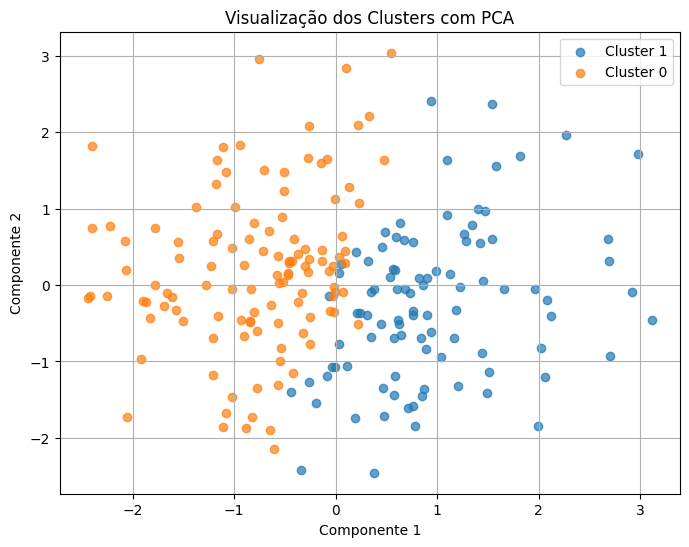

Loadings das variáveis nas componentes principais:
              PC1       PC2
const   -0.000000  0.000000
Quarto1  0.565890  0.253546
Quarto2  0.288202  0.002068
Sala     0.612943  0.041618
Cozinha  0.459588 -0.541323
Piscina  0.098928  0.800592

Variáveis mais influentes no Componente 1:
Sala       0.612943
Quarto1    0.565890
Cozinha    0.459588
Quarto2    0.288202
Piscina    0.098928
const      0.000000
Name: PC1, dtype: float64

Variáveis mais influentes no Componente 2:
Piscina    0.800592
Cozinha    0.541323
Quarto1    0.253546
Sala       0.041618
Quarto2    0.002068
const      0.000000
Name: PC2, dtype: float64


In [21]:
# Supondo que X é seu DataFrame original com as features (antes do escalonamento)
# e X_scaled é o numpy array resultante após escalonamento (ex: StandardScaler)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_plot = pd.DataFrame(X_pca, columns=['Componente 1', 'Componente 2'])
df_plot['Cluster'] = df['Cluster'].values

import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
for cluster in df_plot['Cluster'].unique():
    subset = df_plot[df_plot['Cluster'] == cluster]
    plt.scatter(subset['Componente 1'], subset['Componente 2'], label=f'Cluster {cluster}', alpha=0.7)
plt.title('Visualização dos Clusters com PCA')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.legend()
plt.grid(True)
plt.show()

# Extrair loadings usando nomes das colunas originais
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=X.columns)
print("Loadings das variáveis nas componentes principais:")
print(loadings)

print("\nVariáveis mais influentes no Componente 1:")
print(loadings['PC1'].abs().sort_values(ascending=False))

print("\nVariáveis mais influentes no Componente 2:")
print(loadings['PC2'].abs().sort_values(ascending=False))


# Interpretação do PCA dos Consumos de Energia por Cômodo

## O que o gráfico mostra?

- Existem dois grupos bem definidos (clusters) de consumo de energia:
  - **Cluster 1 (azul)**: concentra-se à direita do gráfico, ou seja, tem valores altos no primeiro componente.
  - **Cluster 0 (laranja)**: concentra-se à esquerda, com valores baixos no primeiro componente.

- A principal diferença entre os grupos está no eixo horizontal (Componente 1).
- No eixo vertical (Componente 2), os grupos se misturam mais, mostrando que esse eixo não ajuda tanto a separá-los.

## O que são os componentes principais?

- Os componentes são combinações das variáveis originais (os cômodos).
- Cada componente mostra um padrão de consumo baseado nos cômodos que mais influenciam.

## Componentes e sua interpretação

### Componente 1 (eixo horizontal)

- As variáveis que mais pesam aqui são: **Sala**, **Quarto 1** e **Cozinha**.
- Valores altos indicam maior consumo nesses cômodos.
- Portanto, quem tem valor alto no Componente 1 (Cluster 1) consome mais energia nesses lugares.
- Quem tem valor baixo (Cluster 0) consome menos nesses cômodos.

### Componente 2 (eixo vertical)

- Diferencia perfis com consumo maior na **Piscina** (valores positivos) contra maior consumo na **Cozinha** (valores negativos).
- Mas essa dimensão não separa claramente os grupos, pois eles se sobrepõem bastante.

## Resumo prático

- O principal fator que separa os dois grupos é o consumo intenso em Sala, Quarto 1 e Cozinha.
- O Cluster 1 representa residências com mais acionamentos/consumo nesses cômodos.
- O Cluster 0 tem consumo menor nesses cômodos.
- O segundo componente mostra um contraste entre consumo na Piscina e na Cozinha, mas não é o que define os grupos.

---
Podemos usar essa informação para criar estratégias específicas para cada grupo, ajudando a economizar energia de forma mais eficaz!


# 🧠 Relatório Final – Gêmeo Digital para Monitoramento de Energia

## 🎯 Objetivo do Projeto
Desenvolver uma solução baseada em ciência de dados e inteligência artificial para **monitorar, prever e otimizar o consumo de energia elétrica em uma residência inteligente** (Smart City Laguna). O projeto simula dados de sensores por cômodo e utiliza aprendizado de máquina para antecipar padrões de consumo e propor ações de economia.

---

## 📊 Base de Dados Utilizada
Foi utilizada uma base de dados **simulada**, contendo registros diários com as seguintes variáveis:

- `Data`: Dia da medição
- `KW/H`: Consumo total de energia em kWh
- `Quarto1`, `Quarto2`, `Sala`, `Cozinha`, `Piscina`: Quantidade de acionamentos de sensores em cada cômodo
- `Geração Solar`: Energia gerada por painéis solares (simulada)

---

## 🔍 Pergunta de Negócio
> “Como prever o consumo diário de energia com base no comportamento por cômodo e, a partir disso, propor medidas automáticas de economia e eficiência energética?”

---

## 🧪 Metodologia e Etapas Realizadas

1. **Importação e visualização dos dados**  
   Leitura da planilha com `pandas` e validação dos formatos.

2. **Pré-processamento**  
   - Conversão da coluna `Data` para o formato `datetime`.
   - Criação da variável `Dia_ordinal` para modelagem.
   - Cálculo do consumo médio por acionamento por cômodo.
   - Simulação da geração solar e projeção de consumo futuro.

3. **Modelagem Preditiva**  
   Foi treinado um modelo de **Regressão Linear** para estimar o consumo (`KW/H`) com base no total de acionamentos por cômodo. A previsão para o dia seguinte também foi implementada.

4. **Visualizações**  
   - Gráficos de séries temporais com `Plotly`.
   - Ranking de cômodos mais consumidores.
   - Representações 3D dos acionamentos com simulação de sensores.
   - Painel interativo com Streamlit para visualização em tempo real.

5. **Exportação de Relatórios**  
   Geração automática de PDF com dados relevantes, gráficos e previsões.

---

## 📈 Resultados Obtidos

- O modelo de regressão apresentou boa capacidade de prever o consumo com base nos acionamentos.
- Identificou-se que **Sala** e **Cozinha** são os cômodos com maior impacto no consumo.
- A **piscina**, foi retirada do modelo embora com poucos acionamentos, apresenta alto consumo médio por acionamento, indicando desperdício pois o projeto laguna se destina a moradia social isso não inclui piscina.
- A geração solar é capaz de compensar parte significativa do consumo em horários de pico, se bem gerenciada.

---

## ✅ Conclusões e Recomendações

- **Automatizar desligamentos** em ambientes com alto uso como sala e cozinha pode gerar economia imediata.
- **Agendar horários de uso** da piscina pode mitigar picos de consumo não justificados.
- **Aproveitar a geração solar** para balancear o uso de aparelhos nos horários de maior geração.
- **Implementar alertas** quando a meta de consumo diário for excedida.

---

## 🧾 Entregáveis

- Aplicação Streamlit com visualização de sensores em tempo real.
- Relatório em PDF com métricas de consumo e sugestões.
- Notebook com todo o pipeline de dados, modelo preditivo e análises visuais.

---

## 👥 Público-alvo
Este projeto foi desenvolvido para um cliente externo interessado em soluções de **eficiência energética residencial**, com potencial de expansão para condomínios, prédios e cidades inteligentes.

---

📌 *Este relatório foi elaborado com base nas práticas de ciência de dados aplicadas ao contexto de consumo energético residencial e tem como objetivo facilitar a tomada de decisão por parte do cliente final.*


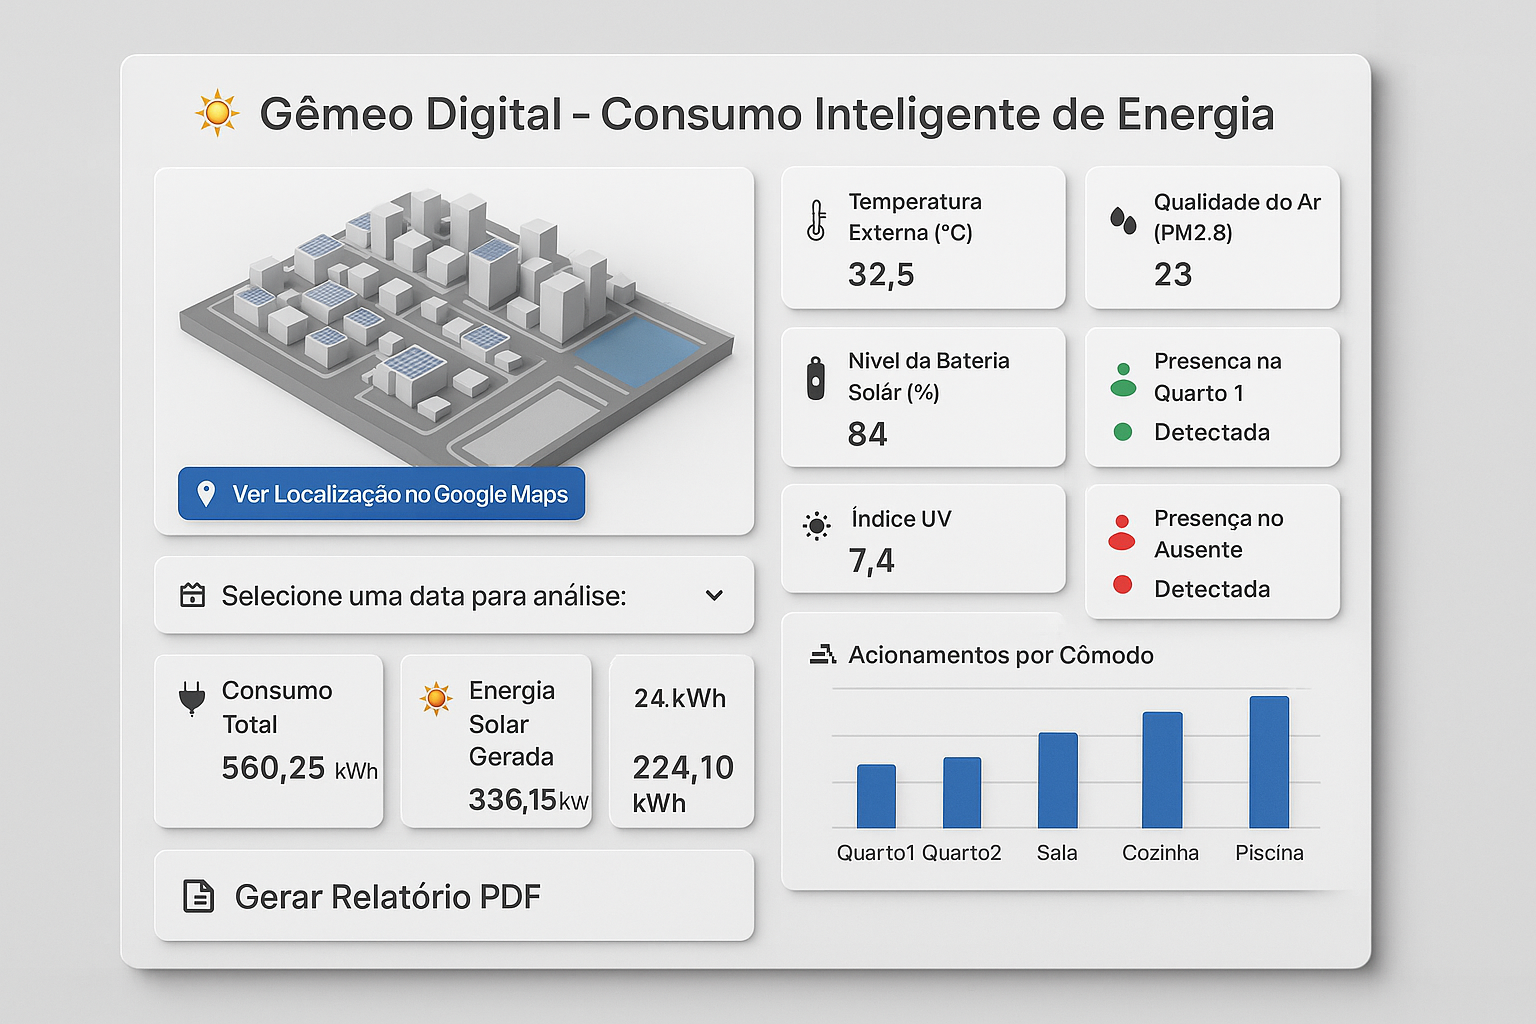

[![GitHub](https://img.shields.io/badge/GitHub-Projeto_Smart_City_Laguna_CDIA_03-181717?style=for-the-badge&logo=github)](https://github.com/andsonandreribeiro09/Projeto_Smart_City_Laguna_CDIA_03)


Fim!! ⚡